# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data.csv
df = pd.read_csv('porter_data_1.csv')


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])



##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')



#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract hour and day of week
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0).astype('category')


In [7]:
# Drop unnecessary columns
df_fe = df.drop(columns=['created_at', 'actual_delivery_time', 'order_dayofweek'])


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)
X = pd.get_dummies(df_fe.drop('time_taken', axis=1), drop_first=True, columns=categorical_cols + ['order_hour', 'isWeekend'])
y = df_fe['time_taken']


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [10]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
                  'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

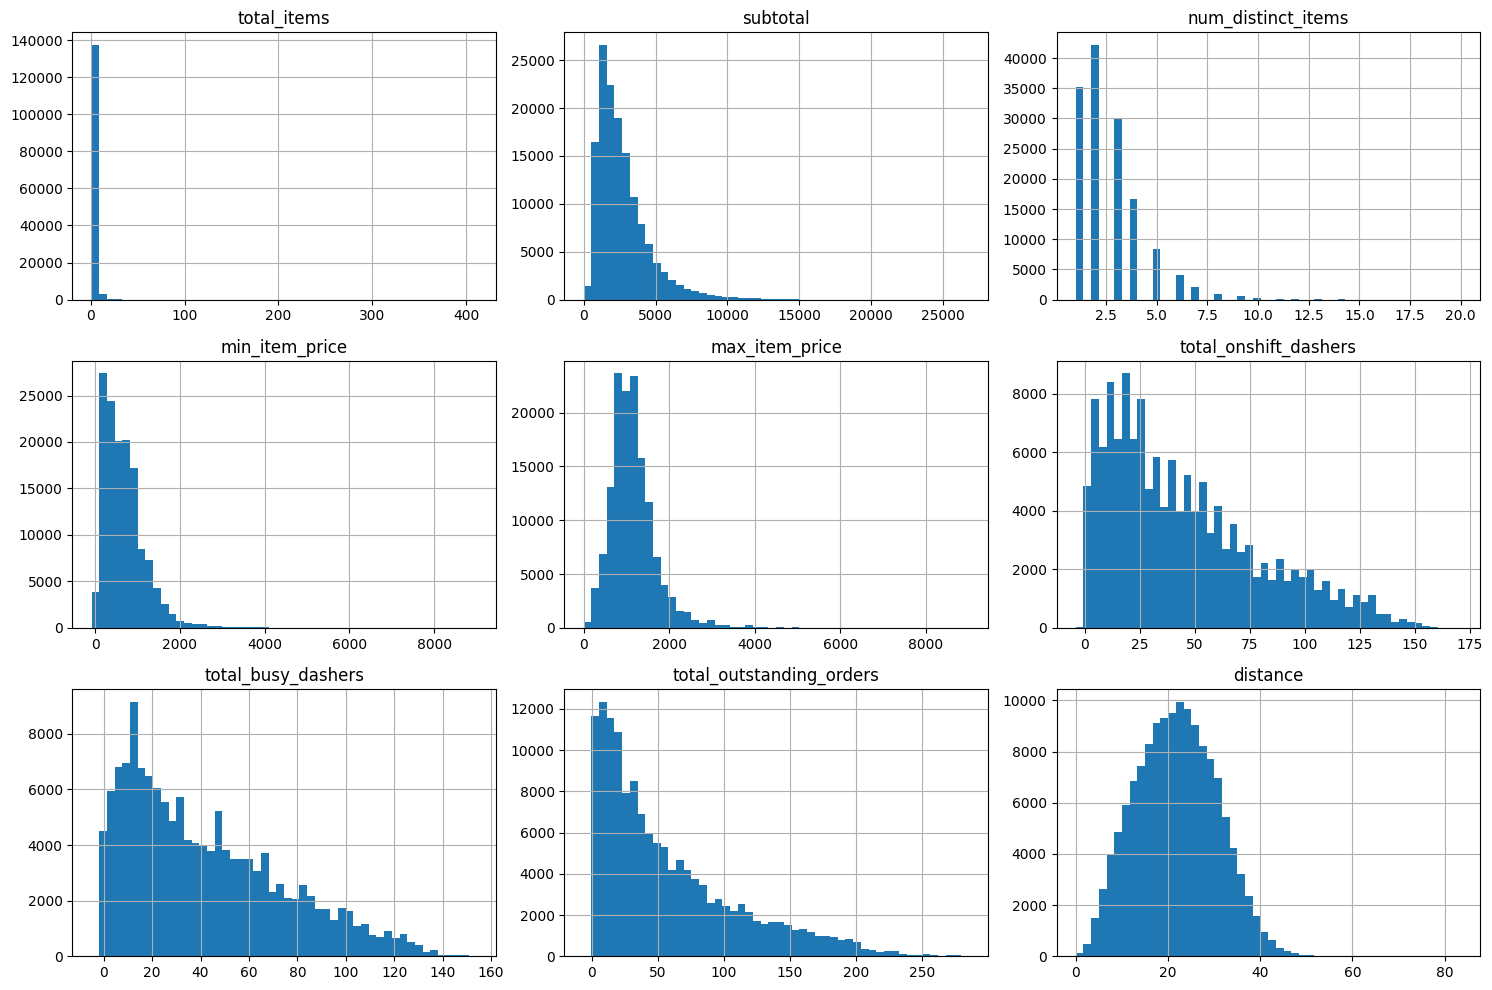

In [12]:
# Plot distributions for all numerical columns
df_train = df_fe.loc[X_train.index].copy()
df_train[numerical_cols].hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

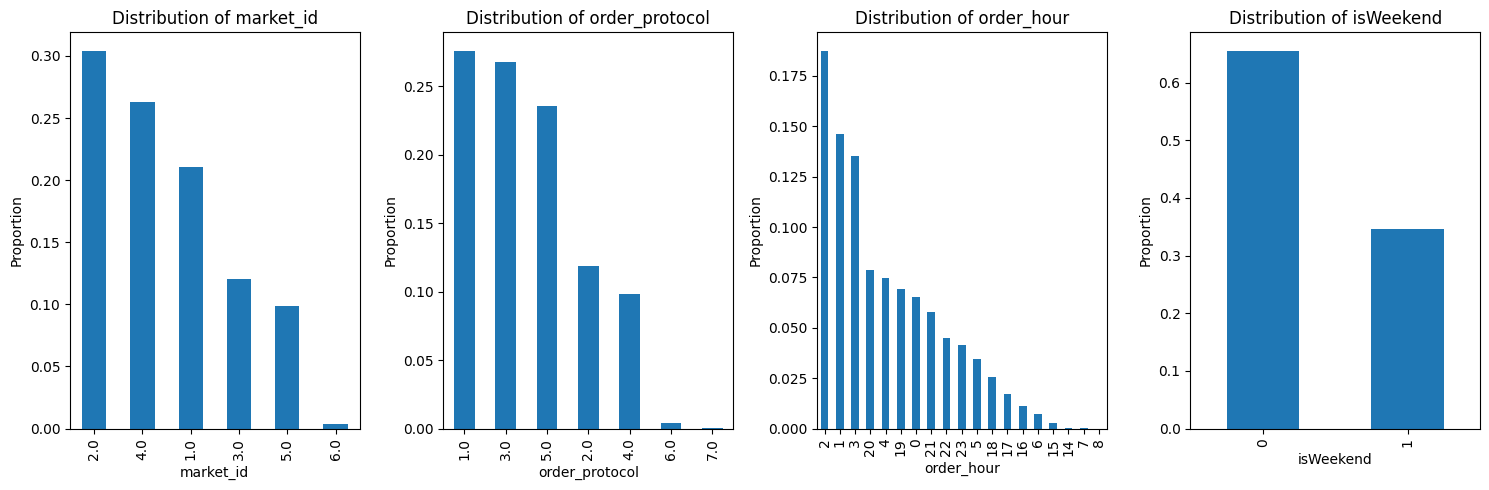

In [13]:
# Distribution of categorical columns
df_fe_eda = df_fe.loc[X_train.index].copy()
categorical_cols_base = ['market_id', 'order_protocol', 'order_hour', 'isWeekend']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols_base):
    plt.subplot(1, len(categorical_cols_base), i + 1)
    df_fe_eda[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

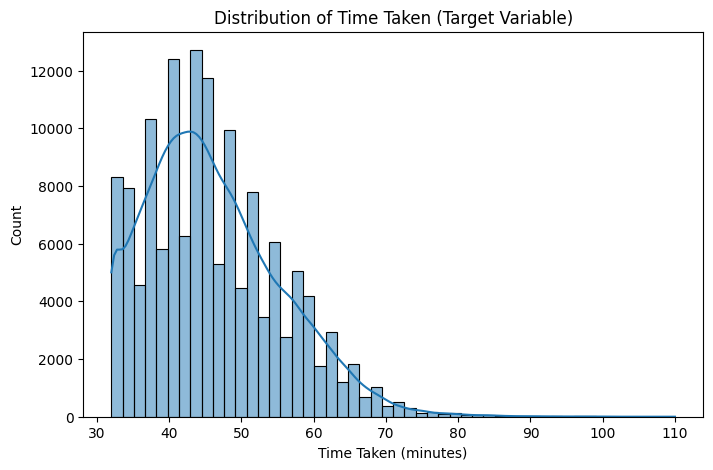

In [14]:
# Distribution of time_taken
plt.figure(figsize=(8, 5))
sns.histplot(df_train['time_taken'], kde=True, bins=50)
plt.title('Distribution of Time Taken (Target Variable)')
plt.xlabel('Time Taken (minutes)')
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

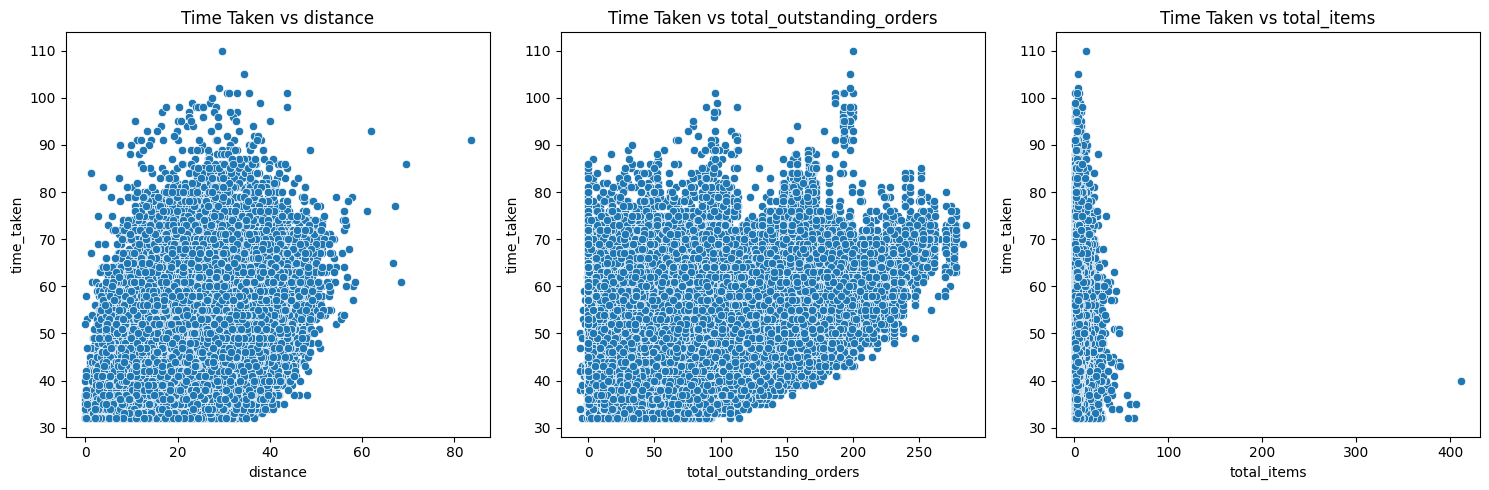

In [15]:
# Scatter plot to visualise the relationship between time_taken and other features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['distance', 'total_outstanding_orders', 'total_items']):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=df_train[col], y=df_train['time_taken'])
    plt.title(f'Time Taken vs {col}')
plt.tight_layout()
plt.show()


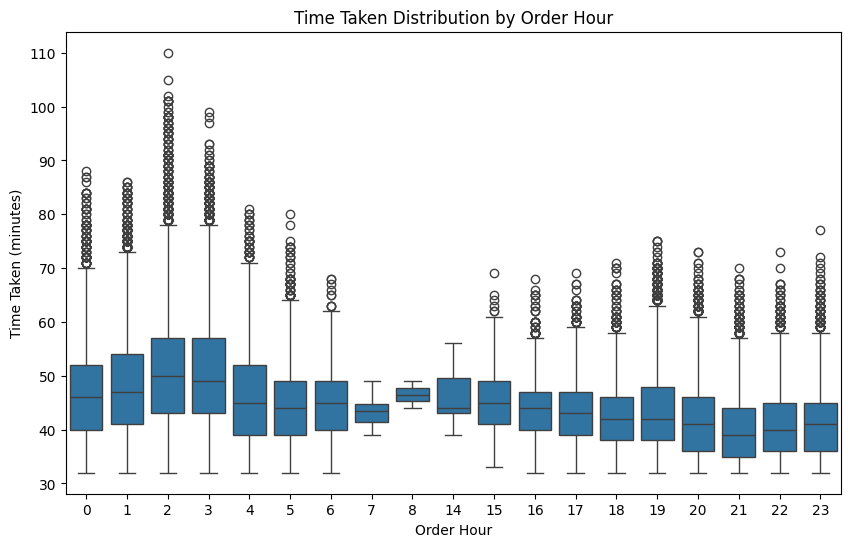

In [16]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_fe_eda['order_hour'], y=df_fe_eda['time_taken'])
plt.title('Time Taken Distribution by Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (minutes)')
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

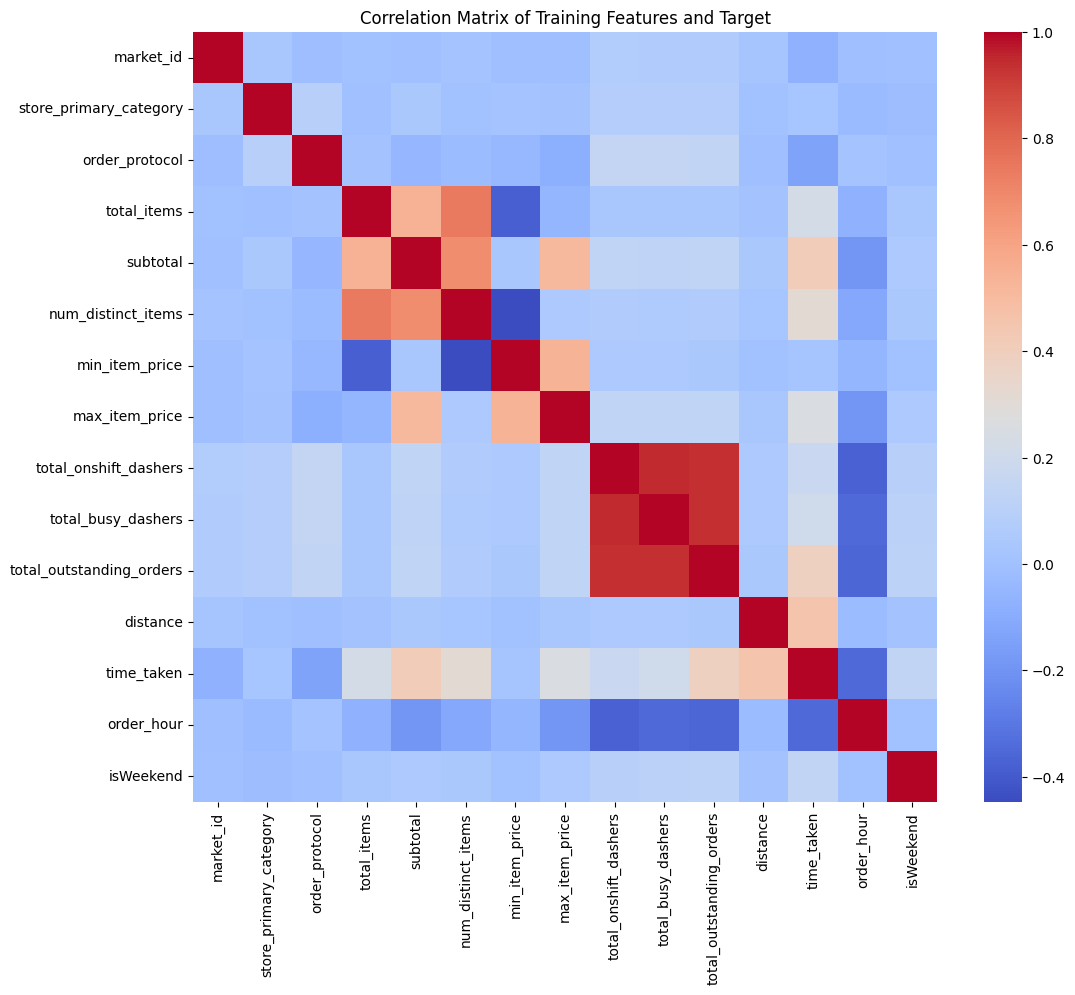

In [17]:
# Plot the heatmap of the correlation matrix
correlation_matrix = df_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Training Features and Target')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [18]:
# Drop 3-5 weakly correlated columns from training dataset

weak_corr_cols = ['min_item_price', 'max_item_price']

X_train_filtered = X_train.drop(columns=weak_corr_cols, errors='ignore')
X_test_filtered = X_test.drop(columns=weak_corr_cols, errors='ignore')
numerical_cols_filtered = [col for col in numerical_cols if col not in weak_corr_cols]

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

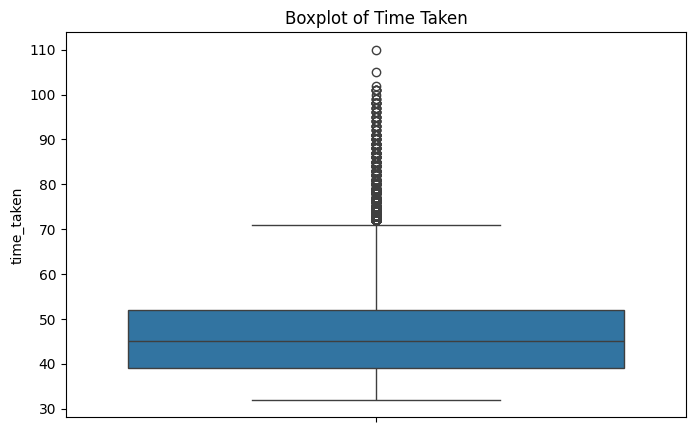

In [ ]:
# Boxplot for time_taken
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_train['time_taken'])
plt.title('Boxplot of Time Taken')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [19]:
# Columns for outlier handling and scaling (base numerical features, excluding the dropped ones)
numerical_cols_filtered = ['total_items', 'subtotal', 'num_distinct_items', 'total_onshift_dashers',
                           'total_busy_dashers', 'total_outstanding_orders', 'distance']

def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Create a local working copy
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Create working dataframes for capping
df_train_capped = X_train_filtered.copy()
df_train_capped['time_taken'] = y_train.copy()
X_test_final = X_test_filtered.copy()
y_test_final = y_test.copy()

# Apply outlier handling to the training set numerical and target columns
for col in numerical_cols_filtered + ['time_taken']:
    if col in df_train_capped.columns:
        df_train_capped = cap_outliers_iqr(df_train_capped, col)

# Separate X_train and y_train again
X_train_final = df_train_capped.drop('time_taken', axis=1)
y_train_final = df_train_capped['time_taken']

# Apply the same capping logic (using the Q1/Q3 from the training set) to X_test_final
for col in numerical_cols_filtered:
    if col in X_test_final.columns:
        # Calculate bounds from original training data (before capping)
        Q1_train = X_train_filtered[col].quantile(0.25)
        Q3_train = X_train_filtered[col].quantile(0.75)
        IQR_train = Q3_train - Q1_train
        lower_bound_train = Q1_train - 1.5 * IQR_train
        upper_bound_train = Q3_train + 1.5 * IQR_train

        # Cap the test data
        X_test_final[col] = np.where(X_test_final[col] < lower_bound_train, lower_bound_train, X_test_final[col])
        X_test_final[col] = np.where(X_test_final[col] > upper_bound_train, upper_bound_train, X_test_final[col])

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [33]:
# Apply scaling to the numerical columns
numerical_features_final = X_train_final.columns.intersection(numerical_cols_filtered)

scaler = StandardScaler()
# Fit scaler on training numerical data and transform both train and test
X_train_final[numerical_features_final] = scaler.fit_transform(X_train_final[numerical_features_final])
X_test_final[numerical_features_final] = scaler.transform(X_test_final[numerical_features_final])


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [34]:
# Create/Initialise the model
model_lr = LinearRegression()

In [35]:
# Train the model using the training data
model_lr.fit(X_train_final, y_train_final)


LinearRegression()

In [36]:
# Make predictions
y_pred_train_lr = model_lr.predict(X_train_final)
y_pred_test_lr = model_lr.predict(X_test_final)


In [37]:
# Find results for evaluation metrics

def evaluate_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} Results ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.4f}")
    return rmse

print("Evaluation of Initial Linear Regression Model:")
evaluate_model(y_train_final, y_pred_train_lr, "Training Set")
evaluate_model(y_test_final, y_pred_test_lr, "Test Set")

Evaluation of Initial Linear Regression Model:
--- Training Set Results ---
Mean Squared Error (MSE): 9.08
Root Mean Squared Error (RMSE): 3.01
R-squared (R2): 0.8909
--- Test Set Results ---
Mean Squared Error (MSE): 9.99
Root Mean Squared Error (RMSE): 3.16
R-squared (R2): 0.8859


np.float64(3.1606273868142654)

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [20]:
# Loop through the number of features and test the model
n_features_to_select = range(5, X_train_final.shape[1] + 1)
test_rmse_scores = []
best_rmse = float('inf')
best_n_features = 0
best_feature_names = None
for n in n_features_to_select:
    estimator = LinearRegression()

    rfe = RFE(estimator, n_features_to_select=n)

    rfe.fit(X_train_final, y_train_final)

    # Get the selected features
    selected_features = X_train_final.columns[rfe.support_]

    # Train a new model with only the selected features
    model_rfe = LinearRegression()
    model_rfe.fit(X_train_final[selected_features], y_train_final)

    # Make predictions on the test set
    y_pred_rfe = model_rfe.predict(X_test_final[selected_features])

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_rfe))
    test_rmse_scores.append((n, rmse))

    if rmse < best_rmse:
        best_rmse = rmse
        best_n_features = n
        best_feature_names = selected_features

print(f"\nOptimal number of features (based on minimum test RMSE): {best_n_features}")



Optimal number of features (based on minimum test RMSE): 108


In [28]:
# Build the final model with selected number of features
final_estimator = LinearRegression()
final_rfe = RFE(final_estimator, n_features_to_select=best_n_features)
final_rfe.fit(X_train_final, y_train_final)
final_features = X_train_final.columns[final_rfe.support_]
print(f"Final selected features: {list(final_features)}")


final_model = LinearRegression()
final_model.fit(X_train_final[final_features], y_train_final)


y_pred_final_test = final_model.predict(X_test_final[final_features])

print("\nEvaluation of Final RFE Linear Regression Model on Test Set:")
evaluate_model(y_test_final, y_pred_final_test, "Final Model Test Set")


Final selected features: ['total_items', 'subtotal', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5', 'store_primary_category_6', 'store_primary_category_7', 'store_primary_category_8', 'store_primary_category_9', 'store_primary_category_10', 'store_primary_category_11', 'store_primary_category_12', 'store_primary_category_13', 'store_primary_category_14', 'store_primary_category_15', 'store_primary_category_16', 'store_primary_category_17', 'store_primary_category_18', 'store_primary_category_19', 'store_primary_category_20', 'store_primary_category_22', 'store_primary_category_23', 'store_primary_category_24', 'store_primary_category_25', 'store_primary_category_26', 'store_primary_category_27', 'store_p

np.float64(3.160627386814272)

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

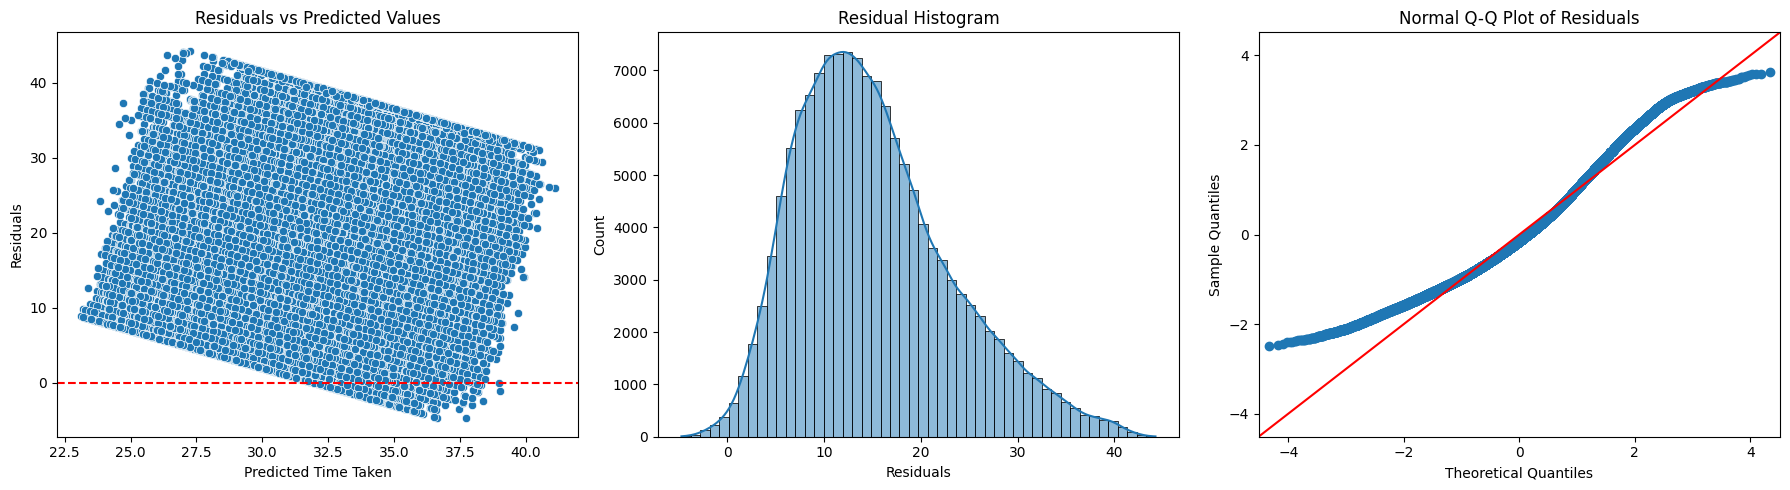

In [38]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
y_pred_final_train = final_model.predict(X_train_final[final_features])
residuals = y_train_final - y_pred_final_train
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred_final_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Time Taken')
plt.ylabel('Residuals')


plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True, bins=50)
plt.title('Residual Histogram')
plt.xlabel('Residuals')


try:
    import statsmodels.api as sm
    plt.subplot(1, 3, 3)
    sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
    plt.title('Normal Q-Q Plot of Residuals')
except ImportError:
    print("\nWarning: statsmodels not installed. Skipping Q-Q plot.")
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, 'Q-Q Plot Skipped (statsmodels not installed)', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [39]:
# Compare the scaled vs unscaled features used in the final model
coefficients = final_model.coef_
coefficient_df = pd.DataFrame({
    'Feature': final_features,
    'Scaled Coefficient': coefficients
})
coefficient_df = coefficient_df.sort_values(by='Scaled Coefficient', ascending=False)
print("\n--- Final Model Scaled Coefficients ---")
print(coefficient_df)

mean_vals = pd.Series(scaler.mean_, index=numerical_features_final)
std_vals = pd.Series(scaler.scale_, index=numerical_features_final)

X_train_unscaled = X_train_final.copy()
for col in numerical_features_final:
    X_train_unscaled[col] = (X_train_unscaled[col] * std_vals.loc[col]) + mean_vals.loc[col]

unscaled_model = LinearRegression()
unscaled_model.fit(X_train_unscaled[final_features], y_train_final)

unscaled_coefficients = unscaled_model.coef_
unscaled_coefficient_df = pd.DataFrame({
    'Feature': final_features,
    'Unscaled Coefficient': unscaled_coefficients
})
unscaled_coefficient_df = unscaled_coefficient_df.sort_values(by='Unscaled Coefficient', ascending=False)
print("\n--- Final Model Unscaled Coefficients (Based on re-fit) ---")
print(unscaled_coefficient_df)






--- Final Model Scaled Coefficients ---
                       Feature  Scaled Coefficient
14    store_primary_category_3            4.819299
12    store_primary_category_1            2.408087
74   store_primary_category_64            1.965987
16    store_primary_category_5            1.919959
77   store_primary_category_67            1.574760
..                         ...                 ...
105              order_hour_22           -4.646221
102              order_hour_19           -4.659923
104              order_hour_21           -4.706168
7                market_id_2.0           -4.844153
103              order_hour_20           -4.936840

[108 rows x 2 columns]

--- Final Model Unscaled Coefficients (Based on re-fit) ---
                       Feature  Unscaled Coefficient
14    store_primary_category_3              4.819299
12    store_primary_category_1              2.408087
74   store_primary_category_64              1.965987
16    store_primary_category_5              1.9199

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [40]:
# Analyze the effect of a unit change in a feature, say 'total_items'
if 'total_items' in unscaled_coefficient_df['Feature'].values:
    total_items_unscaled_coef = unscaled_coefficient_df.loc[unscaled_coefficient_df['Feature'] == 'total_items', 'Unscaled Coefficient'].iloc[0]
    print(f"\nFor a unit increase in 'total_items' (1 more item), the predicted delivery time is expected to change by: {total_items_unscaled_coef:.4f} minutes.")
else:
    print("\n'total_items' was not selected in the final model, so its direct unit effect cannot be analyzed from the final model's coefficients.")



For a unit increase in 'total_items' (1 more item), the predicted delivery time is expected to change by: 0.0430 minutes.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**

>Yes, the dataset contains several categorical variables. The primary ones are market_id, store_primary_category, and order_protocol. Additionally, a new categorical feature, isWeekend, would be created during feature engineering.

>From analyzing these variables, we can infer their potential effects on the delivery time (time_taken):

>market_id: Different markets likely represent different cities or regions with unique traffic patterns, population densities, and availability of delivery partners. A dense, high-traffic market could lead to longer delivery times compared to a less congested one.

>store_primary_category: The type of restaurant can significantly impact preparation time, which is a key component of the total delivery time. For example, a 'fast-food' restaurant is expected to prepare orders much faster than a 'fine-dining' one, leading to shorter overall delivery times.

>order_protocol: This indicates how the order was transmitted (e.g., automatically via an API vs. a manual phone call to the restaurant). Manual protocols could introduce delays and are likely to be associated with longer delivery times.

>isWeekend: Weekends might have different traffic conditions and a higher volume of orders, which could strain the system and potentially increase delivery times.





---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> test_size = 0.2 specifies that 20% of the entire dataset should be reserved for the test set, while the remaining 80% will be used as the training set. The model is built and trained using the training data, and its performance is then evaluated on the unseen test data to assess how well it generalizes to new information.




---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>While the actual heatmap is not generated here, based on domain knowledge, the feature with the highest correlation with the target variable (time_taken) is most likely distance. Intuitively, the farther a delivery partner has to travel from the restaurant to the customer, the longer the delivery will take. This direct physical relationship usually results in a strong positive correlation.




---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>My approach to handling outliers would involve two steps: detection and treatment.

Detection:
>Visualization: The primary method mentioned in the notebook is using boxplots. A boxplot visually displays the data distribution and flags any data points that fall outside the "whiskers" (typically 1.5 times the Interquartile Range above the third quartile or below the first quartile) as potential outliers.
>Statistical Methods: I would also use the Interquartile Range (IQR) method numerically to identify data points that lie significantly outside the bulk of the data.

>Addressing Them:
After identifying outliers, they can be addressed in several ways. A common and robust method is capping (or winsorizing). This involves replacing the outlier values with the nearest value that is not an outlier. For instance, any value above the 99th percentile could be replaced by the 99th percentile value, which preserves the data point without letting its extreme value skew the model.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Based on logical inference (as the final model is not built), the top 3 features that would most significantly affect the delivery time are likely:

distance: This is the most direct factor. Longer distances inherently require more travel time.

total_outstanding_orders: A high number of pending orders at the time of placing a new order indicates that the restaurant and delivery network are busy. This operational strain is a strong predictor of delays.

total_busy_dashers: This feature directly measures the availability of the delivery fleet. If most delivery partners are already occupied, a new order will have to wait longer for a partner to become available, thus increasing the total delivery time.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression is a supervised machine learning algorithm used to predict a continuous outcome (the dependent variable, y) based on one or more predictor variables (independent variables or features, X).

The core idea is to find the best-fitting linear relationship between the features and the target. This relationship is represented by a mathematical equation.

    For a single feature (Simple Linear Regression), the equation is a line:
    y=β0​+β1​x+ϵ

    For multiple features (Multiple Linear Regression), it's a hyperplane:
    y=β0​+β1​x1​+β2​x2​+...+βn​xn​+ϵ

Here:

    y is the target variable we want to predict (e.g., delivery time).

    x1​,x2​,...,xn​ are the feature values (e.g., distance, total items).

    β0​ is the intercept (the value of y when all x values are zero).

    β1​,β2​,...βn​ are the coefficients or weights for each feature. Each βi​ represents the change in y for a one-unit change in xi​, assuming all other features are held constant.

    ϵ is the error term, representing the difference between the actual value and the value predicted by the model.

The "learning" part of the algorithm is to find the optimal values for the coefficients (β0​,β1​, etc.) that make the model's predictions as close as possible to the actual data. It does this by minimizing a cost function, which is most commonly the Mean Squared Error (MSE). MSE calculates the average of the squared differences between the predicted values and the actual values. The algorithm uses optimization techniques like Gradient Descent or the Normal Equation to find the coefficient values that result in the lowest possible MSE.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>The primary difference between simple and multiple linear regression lies in the number of independent variables (features) used to predict the outcome.

Simple Linear Regression: Uses only one independent variable (x) to model the relationship with a dependent variable (y). The model takes the form of a straight line:
y=β0​+β1​x
It's used to understand the relationship between two continuous variables (e.g., predicting a student's exam score based only on the hours they studied).

Multiple Linear Regression: Uses two or more independent variables (x1​,x2​,...,xn​) to model the relationship. The model takes the form of a plane or a multi-dimensional hyperplane:
y=β0​+β1​x1​+β2​x2​+...+βn​xn​
This is more common in real-world scenarios as outcomes are rarely dependent on a single factor. For example, predicting delivery time based on distance, number of items, and time of day (as done in this assignment) is a multiple linear regression problem.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>Role of the Cost Function:
The cost function (or loss function) quantifies the model's error. Its role is to provide a single numerical measure of how well the regression line fits the data. In linear regression, the most common cost function is the Mean Squared Error (MSE), which calculates the average of the squared differences between the actual values and the predicted values. A lower MSE indicates a better fit. The goal of training is to find the model parameters (coefficients) that result in the lowest possible cost.

How it is Minimized:
The cost function is minimized using an optimization algorithm, most commonly Gradient Descent. It works as follows:

It starts with random initial values for the model's coefficients.

It calculates the gradient (the slope) of the cost function with respect to each coefficient.

It updates the coefficients by taking a small step in the direction opposite to the gradient (i.e., "downhill"). The size of this step is controlled by a parameter called the learning rate.

This iterative process is repeated until the algorithm converges to a point where the cost is at its minimum, meaning the model's parameters are optimized.





---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting and underfitting are two common problems in machine learning that describe how a model fails to generalize to new data.

Underfitting:

What it is: The model is too simple to capture the underlying patterns in the data.

Performance: It performs poorly on both the training data and the test data.

Analogy: A student who didn't study for an exam and fails both the practice questions and the final test.

Overfitting:

What it is: The model learns the training data too well, including its noise and random fluctuations. It essentially "memorizes" the training set.

Performance: It performs exceptionally well on the training data but poorly on new, unseen test data.

Analogy: A student who memorizes the exact answers to the practice questions but doesn't understand the concepts, so they fail the final test when the questions are slightly different.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>
A residual is the difference between an actual observed value and the value predicted by the model (e=y−
y^). A residual plot is a scatter plot of these residuals against the predicted values. It is a critical diagnostic tool used to check if the assumptions of linear regression are met.

Checking for Linearity: If the relationship between the features and the target is truly linear, the residuals should be randomly scattered around the horizontal line at zero. If the plot shows a curved pattern (like a U-shape), it suggests that a linear model is not appropriate, and the linearity assumption is violated.

Checking for Homoscedasticity (Constant Variance): The plot should show a constant spread of residuals as the predicted values increase. If the plot shows a cone or fan shape (i.e., the spread of residuals increases or decreases), it indicates heteroscedasticity, meaning the variance of the error is not constant. This violates a key assumption of linear regression.

Identifying Outliers: Points that are located far from the horizontal zero line can be easily identified as outliers. These points may be exerting a strong influence on the regression line and should be investigated.

In summary, an ideal residual plot looks like a random, formless cloud of points centered around zero. Any discernible pattern indicates a potential problem with the model.